**📦 1. Imports and Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

**📂 2. Load and Combine Data**

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
external = pd.read_csv('/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

external = pd.concat([external] * 7, ignore_index=True)

**🧹 3. Preprocessing**

In [3]:
def preprocess(df, label_encoders=None, fit=False):
    df = df.copy()
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    if 'Personality' in df.columns:
        y = df.pop('Personality')
    else:
        y = None

    if label_encoders is None:
        label_encoders = {}

    for col in df.select_dtypes(include='object').columns:
        if fit:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            df[col] = le.transform(df[col].astype(str))

    return df, y, label_encoders

X_train, y_train, label_encoders = preprocess(train, fit=True)
X_test, _, _ = preprocess(test, label_encoders)
X_external, y_external, _ = preprocess(external, label_encoders)

target_encoder = LabelEncoder()
y_train_enc = target_encoder.fit_transform(y_train)
y_external_enc = target_encoder.transform(y_external)


**⚙️ 4. XGBoost Parameters**

In [4]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_leaves': 25,
    'min_child_weight': 0.0034,
    'learning_rate': 0.0947,
    'n_estimators': 10000,
    'subsample': 0.8025,
    'colsample_bylevel': 0.8360,
    'colsample_bytree': 0.8733,
    'reg_alpha': 0.0029,
    'reg_lambda': 27.126,
    'random_state': 42,
    'tree_method': 'hist',
    'device': 'cuda'
}

**🔁 5. Cross-Validation**

In [5]:
def train_with_cv(X, y, X_ext, y_ext, params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    best_iterations = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Training Fold {fold}/{n_splits}...")
        X_train_fold = pd.concat([X.iloc[train_idx], X_ext])
        y_train_fold = np.concatenate([y[train_idx], y_ext])
        X_val_fold = X.iloc[val_idx]
        y_val_fold = y[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            early_stopping_rounds=50,
            verbose=False
        )
        preds = model.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, preds)
        scores.append(acc)
        best_iterations.append(model.best_iteration)
        print(f"Fold {fold} Accuracy: {acc:.4f}, Best Iteration: {model.best_iteration}")

    return scores, best_iterations

cv_scores, best_iters = train_with_cv(X_train, y_train_enc, X_external, y_external_enc, xgb_params)
print(f"\nAverage CV Accuracy: {np.mean(cv_scores):.4f}")

Training Fold 1/5...
Fold 1 Accuracy: 0.9692, Best Iteration: 72
Training Fold 2/5...
Fold 2 Accuracy: 0.9665, Best Iteration: 62
Training Fold 3/5...
Fold 3 Accuracy: 0.9657, Best Iteration: 67
Training Fold 4/5...
Fold 4 Accuracy: 0.9706, Best Iteration: 93
Training Fold 5/5...
Fold 5 Accuracy: 0.9714, Best Iteration: 61

Average CV Accuracy: 0.9687


**🧠 6. Final Training**

In [6]:
best_n_estimators = int(np.mean(best_iters))
print(f"\nTraining final model with {best_n_estimators} estimators...")
xgb_params_final = xgb_params.copy()
xgb_params_final['n_estimators'] = best_n_estimators

final_model = xgb.XGBClassifier(**xgb_params_final)
final_model.fit(X_train, y_train_enc)



Training final model with 71 estimators...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.836, colsample_bynode=None,
              colsample_bytree=0.8733, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0947, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=25,
              min_child_weight=0.0034, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=71, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

**📊 7. Feature Importance Plot**

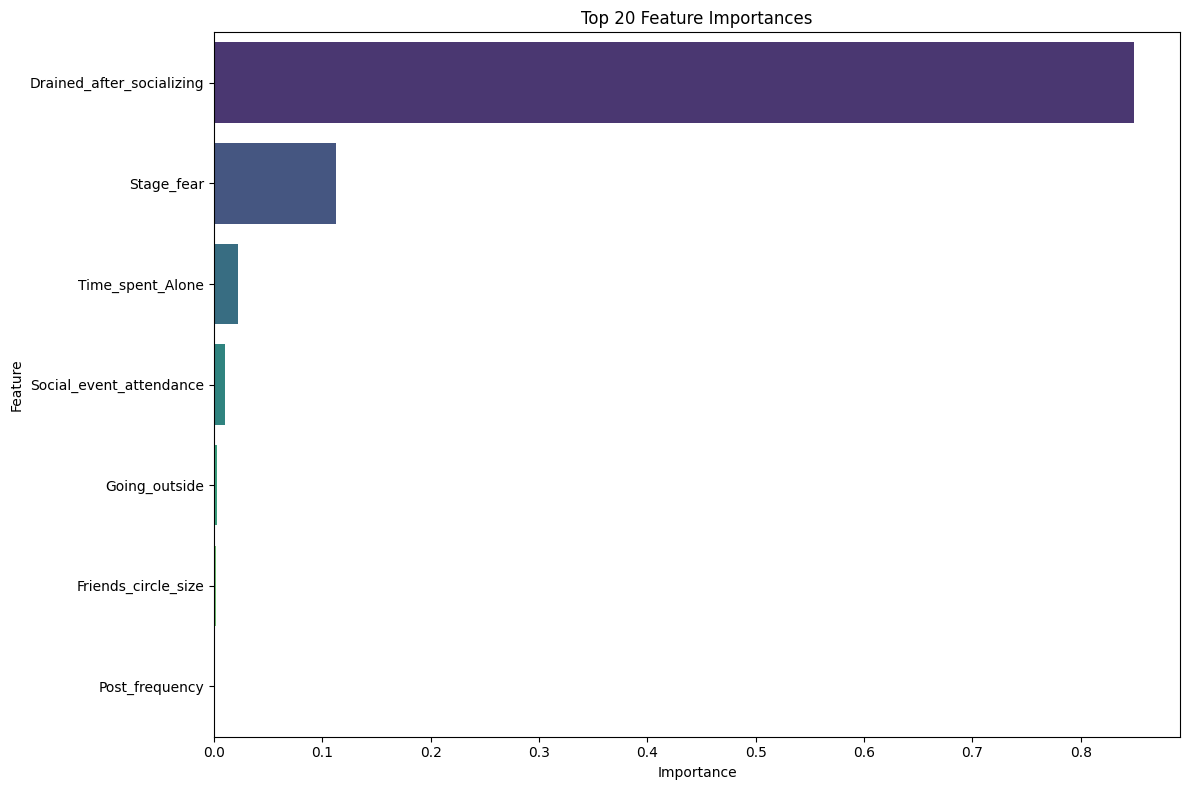

In [7]:
importances = final_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


**📤 8. Predict and Submit**

In [8]:
test_preds = final_model.predict(X_test)
test_preds_labels = target_encoder.inverse_transform(test_preds)

submission = sample_submission.copy()
submission['Personality'] = test_preds_labels
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
